# Simple Tv Series multi-label Clasification Using method Classifier Chains ######
___
En los problemas de clasificación multi-etiqueta se requiere predecir ya no sólo un valor como en el problema de clasificación multi-clase, sino un conjunto de valores. Para ello, hay dos enfoques para abordar el problema:
1. Adaptación del algoritmo.
2. Transformación del problema.


En el primer enfoque existen varias adaptaciones de algoritmos:
* árboles de decisión : se modifica para que las hojas tengan más de una clase
* campos aleatorios de Cadenas de markov: se modifica para considerar co-ocurrencias de etiquetas
* redes neuronales : Adaptan RNN backpropagation para incorporar multi-etiquetas
* KNN(K-Neighbooor Nearest),etc.

En el segundo enfoque, transformamos el problema en varios problemas de clasificación multiclase. Existen varios métodos o estrategía para esto, como los métodos de Rakel, Binario Relevance, Classifer Chains,etc. <br>
* Label Powerset : considera cada subconjunto diferente de etiquetas como una clase dentro de un nuevo problema de clasificación multiclase.
* Binario Relevance : Este método genera n clasificadores, un clasificador por cada clase, convirtiendo en un problema de n clasificaciones binarias.
* Rakel: Random Label Powersets, hace un ensamble de Label Powersets, donde se hacen subconjuntos pequeños de las nuevas clases para cada clasificador. La ventaja es que mantiene la correlación de etiquetas y número de clases reducido.
* Classifer Chains :  Construye una cadena de regla bayesiana de clasificadores, donde el primer clasificador tiene como entrada  los feutures, el segundo clasificador los feutures y el resultado del anterior clasificador y así sucesivamente hasta el último clasificador de la cadena. Esto permite que no se pierdan la carrelación entre las clases y lo hace escalable en problemas con mucha etiquetas.Para más detalles, les dejo un link https://www.cs.waikato.ac.nz/~eibe/pubs/chains.pdf

### Descripción y objetivo del ejemplo ####

El objetivo del ejemplo es hacer un análisis de un problema multi-etiqueta desde el enfoque de transformación del problema y a la vez mostrar un análisis de text mining. <br>
**Descripción de los datos** <br>Se tiene una data de series de TV sacada utilizando web scraping (notebook [aquí](https://github.com/Jasonwmr/Data_Science_with_python/blob/master/Web_Scraping/sensac.ipynb)) que contiene el nombre de la serie, la sinopsis y a qué generos pertenece. <br> 
**_El objetivo es poder conocer a qué generos pertenece una serie de televisión conociendo sólo la sinopsis de la serie._**

###### Librerias de manejo y exploración de datos

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###### Librerias para Text Mining

In [4]:
import string 
import re
from nltk.corpus import stopwords # para excluir palabras 
from nltk.stem.wordnet import WordNetLemmatizer # lematizar : para transformar las palabra a un estadod mjor
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

#### Librerias para  machine learning

In [5]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [6]:
datos = pd.read_csv('../datos/tablas_series_tv.csv',sep=";").drop('Unnamed: 0',axis=1)

## Exploración de Datos
***

In [7]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
Titulo      4800 non-null object
Sinopsis    4162 non-null object
Genero      4800 non-null object
dtypes: object(3)
memory usage: 112.6+ KB


In [8]:
datos.head()

,Titulo,Sinopsis,Genero
0,#Cartel,#Cartel es una serie dramática de televisión d...,"Suspense,Judicial"
1,'Allo 'Allo,La vida es cualquier cosa menos simple para Re...,Comedia
2,(Des)encanto,(Des)encanto es una comedia de animación para ...,"Fantasía,Animación"
3,+ De 100 Mentiras,+ De 100 Mentiras narra la historia de un hack...,"Drama,Suspense"
4,10,NaN,Drama


Hay series que su sinopsis está vacía, por lo tanto se eliminan.

In [9]:
datos = datos.dropna().reset_index(drop=True)
datos.head()

,Titulo,Sinopsis,Genero
0,#Cartel,#Cartel es una serie dramática de televisión d...,"Suspense,Judicial"
1,'Allo 'Allo,La vida es cualquier cosa menos simple para Re...,Comedia
2,(Des)encanto,(Des)encanto es una comedia de animación para ...,"Fantasía,Animación"
3,+ De 100 Mentiras,+ De 100 Mentiras narra la historia de un hack...,"Drama,Suspense"
4,10 Razones para odiarte,"En el colegio Padua High, las hermanas Kat y B...",Comedia


###### Variable Género : construcción y análisis del target 
Se observa que después de romántico la frecuencia baja cerca a cero.

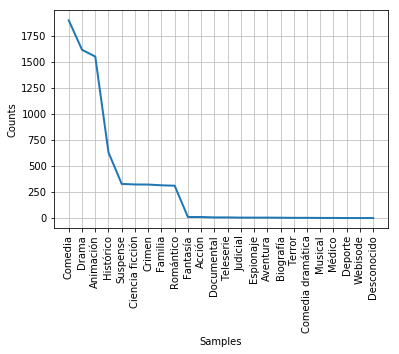

FreqDist({'Comedia': 1896, 'Drama': 1614, 'Animación': 1549, 'Histórico': 630, 'Suspense': 328, 'Ciencia ficción': 323, 'Crimen': 322, 'Familia': 315, 'Romántico': 311, 'Fantasía': 11, ...})

In [10]:
c = [i.split(',') for i in datos.Genero]#descomponemos los generos de la serie a un lista de géneros de cada serie
generos = [i for j in c for i in j]# juntamos todo en un lista
frec_genro = FreqDist(generos) # contamos la frecuencia de aparición de los generos
frec_genro.plot()#graficamos 
frec_genro# mostramos en número

Nos quedamos con los géneros de las series que tienen una presencia significativa.

In [11]:
Genro = np.array(['Comedia','Drama', 'Animación', 'Histórico','Suspense','Ciencia ficción','Crimen','Familia','Romántico'])

##### Construimos una tabla de dummies género de las series de tv

Construcción de la tabla con ceros.

In [12]:
Genro_dummies = pd.DataFrame(np.zeros((datos.shape[0],len(Genro))),columns=Genro)
Genro_dummies.head()

,Comedia,Drama,Animación,Histórico,Suspense,Ciencia ficción,Crimen,Familia,Romántico
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Con el método str.find puedo encontrar la posición de una palabra dentro de un texto.
- datos.Genero[0] # 'Suspense,Judicial'
- datos.Genero[0].find('Suspense') # 0; me da la posición  de 'Suspense' en el texto
- En caso la posición sea negativa, significa que la palabra no se encuentra.

Se preguntará la posición para cada género. Si la posición es mayor o igual a cero se cambia a valor de 1, de lo contrario sigue siendo cero.

In [13]:
for i in Genro :
    Genro_dummies[i]= np.int0(datos.Genero.str.find(i)>=0)
Genro_dummies.head()

,Comedia,Drama,Animación,Histórico,Suspense,Ciencia ficción,Crimen,Familia,Romántico
0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0


Contamos los casos que están asignados a al menos un género y cuantos casos no lo están (no están porque pertencieron a sólo a los géneros sin presencia significativa).

In [14]:
filt_casos = Genro_dummies.apply(sum,axis=1)>0
sum(filt_casos==True),sum(filt_casos==False) #11 casos que deben pertencer a los genero sin presencia significativa

(4151, 11)

Sólo salen 11 casos

In [15]:
datos_f = datos.loc[filt_casos,:]
Genro_dummies = Genro_dummies[filt_casos]

DataFrame final

In [16]:
datos_new = pd.concat([datos[filt_casos],Genro_dummies],axis=1)

In [17]:
datos_new.shape,datos.shape

((4151, 12), (4162, 3))

In [18]:
datos_new.head()

,Titulo,Sinopsis,Genero,Comedia,Drama,Animación,Histórico,Suspense,Ciencia ficción,Crimen,Familia,Romántico
0,#Cartel,#Cartel es una serie dramática de televisión d...,"Suspense,Judicial",0,0,0,0,1,0,0,0,0
1,'Allo 'Allo,La vida es cualquier cosa menos simple para Re...,Comedia,1,0,0,0,0,0,0,0,0
2,(Des)encanto,(Des)encanto es una comedia de animación para ...,"Fantasía,Animación",0,0,1,0,0,0,0,0,0
3,+ De 100 Mentiras,+ De 100 Mentiras narra la historia de un hack...,"Drama,Suspense",0,1,0,0,1,0,0,0,0
4,10 Razones para odiarte,"En el colegio Padua High, las hermanas Kat y B...",Comedia,1,0,0,0,0,0,0,0,0


Gráfica de casos multi-etiqueta.

In [19]:
a = Genro_dummies.apply(lambda x : ','.join(x.astype(str)),axis=1)
b = pd.crosstab(a,True)
c = list(b.index.str.split(','))
d = [[bool(int(i)) for i in d] for d in c]

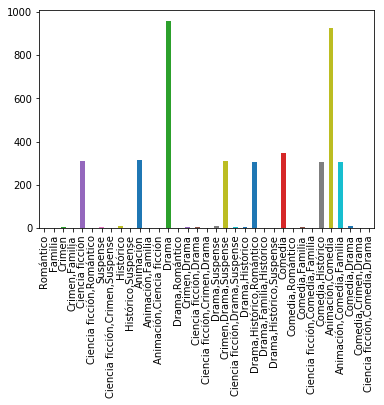

In [20]:
res_gnero = pd.Series(b.values.reshape(b.values.shape[0]),index=[','.join(np.unique(Genro[i])) for i in d])
res_gnero.plot.bar()

###### Limpieza, transformación y preparación de textos

In [21]:
stop = stopwords.words('spanish')

In [22]:
stop.extend(['comedia', 'crama', 'animación', 'histórico', 'suspense', 'crimen','siencia ficción',
       'familia', 'romántico'])
exclude = set(string.punctuation) 

In [23]:
# Lemmatizacion de las palabras 
lemma = WordNetLemmatizer() 
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    normalized2 = " ".join(list(set([i for i in normalized.split() if i not in stop])))
    return normalized2

Sin limpieza de texto

In [24]:
plt.figure(figsize=(200,200))
wordcloud = WordCloud(
            background_color ='white',
            min_font_size = 10,max_words=20).generate(' '.join(datos_f.Sinopsis))
plt.imshow(wordcloud)

Con limpieza de Texto 

In [25]:
datos_new['Sinopsis']=[clean(i) for i in datos_new.Sinopsis]#la limpieza se puede optimizar más

In [26]:
plt.figure(figsize=(200,200))
wordcloud = WordCloud(
            background_color ='white',
            min_font_size = 5,max_words=100).generate(' '.join(datos_new.Sinopsis))
plt.imshow(wordcloud)

#### Preparación para training

In [27]:
# El metodo CountVectorizer de sklearn hace todo el preprocesamiento junto, stopwords, lowercase;tokenizacion usando regex
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words=stop, lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
X= vectorizer.fit_transform(datos_new.Sinopsis)

y = Genro_dummies


#### Training model

In [28]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=41)

In [29]:
classifier = ClassifierChain(DecisionTreeClassifier())
classifier.fit(Xtrain, ytrain)

ClassifierChain(classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
        order=None, require_dense=[True, True])

In [30]:
predictions = classifier.predict(Xtest)

In [31]:
Genro

array(['Comedia', 'Drama', 'Animación', 'Histórico', 'Suspense',
       'Ciencia ficción', 'Crimen', 'Familia', 'Romántico'], dtype='<U15')

In [32]:
print(classification_report(ytest,predictions,
                            target_names=Genro))

                 precision    recall  f1-score   support

        Comedia       0.98      0.98      0.98       622
          Drama       0.98      0.96      0.97       542
      Animación       0.98      1.00      0.99       510
      Histórico       0.97      0.98      0.97       214
       Suspense       0.93      0.93      0.93       120
Ciencia ficción       0.98      0.98      0.98        96
         Crimen       0.96      0.96      0.96       114
        Familia       0.96      1.00      0.98        95
      Romántico       0.97      1.00      0.99       106

    avg / total       0.97      0.98      0.98      2419

